# Rates carry

#### Author: Prof. Gustavo Soares

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Data

We can use use [FinanceHub's rates tracker builder](https://github.com/Finance-Hub/FinanceHub/tree/master/trackers/Rates) to create excess return indices for interest rate swaps. Also, we can use the same code to calculate a carry signal along th lines of [Koijen, Moskowitz, Pedersen, and Vrugt (2016)](https://ssrn.com/abstract=2298565).

Let's grab that data:

In [2]:
trackers = pd.read_csv('irs_trackers.csv', index_col=0)
trackers.index = pd.to_datetime(trackers.index)
trackers = trackers.astype(float)
carry = pd.read_csv('rates_carry.csv', index_col=0)
carry.index = pd.to_datetime(carry.index)
carry = carry.astype(float)

### Smoothing signals

Often times, signals can be very noisy. It is common to try to smooth out time variation on signals. [Koijen, Moskowitz, Pedersen, and Vrugt (2016)](https://ssrn.com/abstract=2298565) for example use two definitions of carry, (i) the raw carry signal and a moving average of the current carry over the past 12 months (including the most recent one). Let's take a look at a faster smoothing using 3M window:

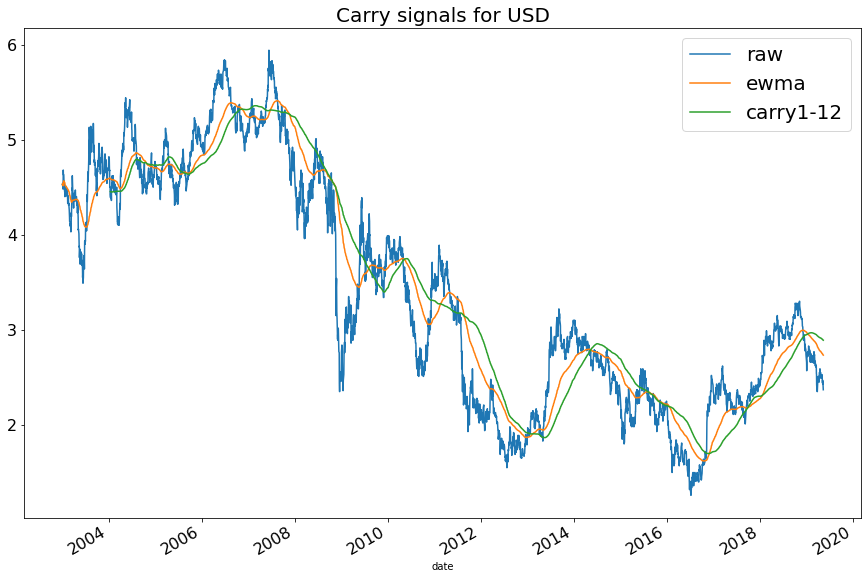

In [3]:
ccy = 'USD'
raw_signal_for_ccy = carry[ccy].to_frame('raw')
ewma_signal_for_ccy = (carry[ccy].ewm(halflife=63).mean()).to_frame('ewma')
rolling_signal_for_ccy = (carry[ccy].rolling(252).mean()).to_frame('carry1-12')
s_for_ccy = pd.concat([raw_signal_for_ccy,
                       ewma_signal_for_ccy,
                       rolling_signal_for_ccy], axis=1, sort=True)
s_for_ccy.plot(figsize=(15,10), fontsize=16)
plt.title('Carry signals for %s' % ccy, fontsize=20)
plt.legend(fontsize=20)
plt.show()

### Carry Trade Portfolio

Following [Koijen, Moskowitz, Pedersen, and Vrugt (2016)](https://ssrn.com/abstract=2298565), let's carry-trade portfolios using ranks:

In [4]:
signals = carry.ewm(halflife=63).mean().shift(1).dropna(how='all')
ranks = signals.rank(axis=1)
weights = ranks.subtract(ranks.mean(axis=1), axis=0).fillna(0)
weights = 2 * weights.divide(weights.abs().sum(axis=1), axis=0)

#### Backtest of the carry trade

In [5]:
# initial set up
backtest = pd.Series(index=weights.index, dtype=float)
backtest.iloc[0] = 100 # initialize the backtest with 100
start_date = backtest.index[0]

# first trade
prices = trackers.loc[start_date]
holdings = (backtest.iloc[0] * weights.loc[start_date] / prices).fillna(0)

# loop over the next days
for i in range(1, backtest.shape[0]):
    tdy = backtest.index[i]
    yst = backtest.index[i-1]
            
    # calculate pnl on the day
    deltap = trackers.loc[tdy] - trackers.loc[yst]
    pnl = (holdings*deltap).sum()
    backtest.iloc[i] = backtest.iloc[i-1] + pnl
    
    if tdy.month != yst.month: #
        prices = trackers.loc[tdy]
        notionals = backtest.iloc[i-1] * weights.loc[yst]        
        holdings = (notionals / prices).fillna(0)

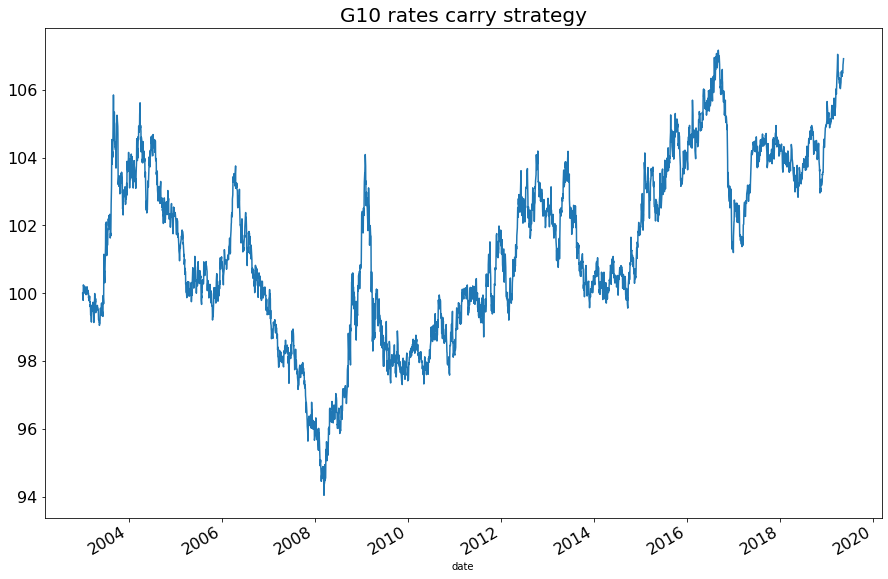

In [6]:
backtest.plot(figsize=(15,10), fontsize=16)
plt.title('G10 rates carry strategy', fontsize=20)
plt.show()

### Carry Timing Portfolio

Again, following [Koijen, Moskowitz, Pedersen, and Vrugt (2016)](https://ssrn.com/abstract=2298565), now consider a carry timing strategy within each currency to analyze the time-series predictability of carry in FX:

In [7]:
weights2 = np.sign((signals - signals.expanding(63).mean()).dropna(how='all'))
weights2 = 2 * weights2.divide(weights2.abs().sum(axis=1), axis=0)

#### Backtest of the carry timing

In [8]:
# initial set up
backtest2 = pd.Series(index=weights2.index, dtype=float)
backtest2.iloc[0] = 100 # initialize the backtest with 100
start_date = backtest2.index[0]

# first trade
prices = trackers.loc[start_date]
holdings = (backtest2.iloc[0] * weights2.loc[start_date] / prices).fillna(0)

# loop over the next days
for i in range(1, backtest2.shape[0]):
    tdy = backtest2.index[i]
    yst = backtest2.index[i-1]
            
    # calculate pnl on the day
    deltap = trackers.loc[tdy] - trackers.loc[yst]
    pnl = (holdings*deltap).sum()
    backtest2.iloc[i] = backtest2.iloc[i-1] + pnl
    
    if tdy.month != yst.month: #
        prices = trackers.loc[tdy]
        notionals = backtest2.iloc[i-1] * weights2.loc[yst]        
        holdings = (notionals / prices).fillna(0)

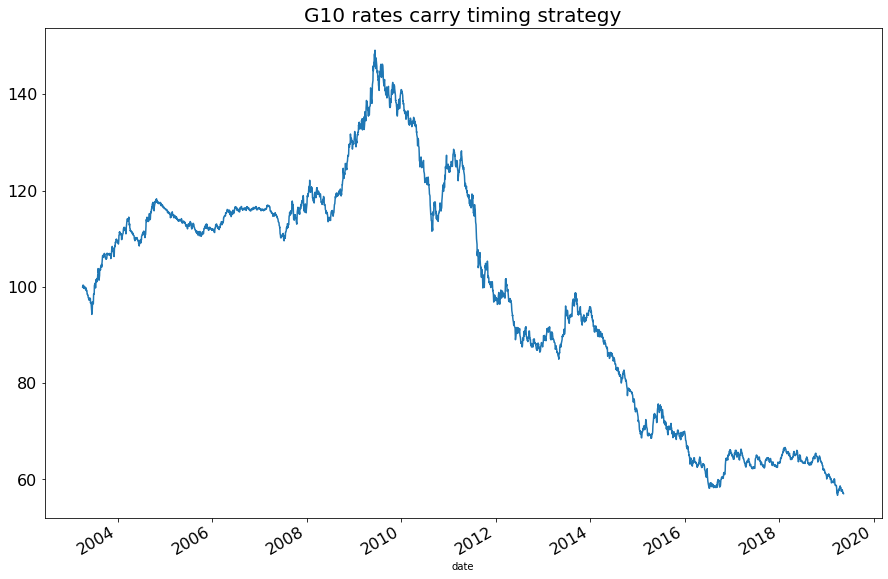

In [9]:
backtest2.plot(figsize=(15,10), fontsize=16)
plt.title('G10 rates carry timing strategy', fontsize=20)
plt.show()